In [1]:
!pip install timm --quiet

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import transforms3d.quaternions as quat
from scipy import signal
import scipy.fft as sfft
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
def estimate_depth(image_path):
    model_type = "DPT_Large"
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    transform = Compose([
        Resize(384),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert('RGB')
    input_batch = transform(img).to(device).unsqueeze(0)

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.size[::-1],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output_depth = prediction.cpu().numpy()
    return output_depth

In [4]:
def extract_and_match_features(image1, image2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    image1_with_keypoints = cv2.drawKeypoints(image1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image2_with_keypoints = cv2.drawKeypoints(image2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image1_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title('Image 1 with SIFT Keypoints')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image2_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title('Image 2 with SIFT Keypoints')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return points1, points2

In [5]:
def derive_3d_points(matched_points_2d, depth_map):
    points_3d = []
    for x, y in matched_points_2d:
        depth = depth_map[int(y), int(x)]
        points_3d.append([x, y, depth])
    return np.array(points_3d)

In [6]:
def estimate_pose(points_3d, points_2d, camera_matrix):
    _, rvec, tvec = cv2.solvePnP(points_3d, points_2d, camera_matrix, None)
    return rvec, tvec

### Step 1 Feature Matching

In [7]:
root = '/home/lausena/developer/repos/spacecraft-pose-pose-estimation-runtime/'
reference_path = os.path.join(root, 'data/images/01f0f7459b/000.png')
target_path = os.path.join(root, 'data/images/01f0f7459b/001.png')

reference_image = cv2.imread(reference_path)
target_image = cv2.imread(target_path)

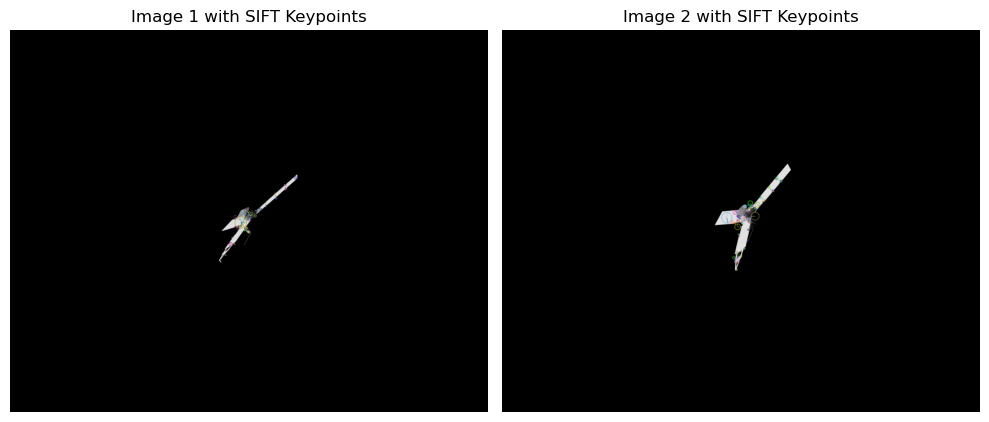

In [8]:
matched_points_ref, matched_points_target = extract_and_match_features(reference_image, target_image)

### Step 2 : Depth Estimation

In [9]:
depth_map_target = estimate_depth(target_path)
depth_map_target

Using cache found in /home/lausena/.cache/torch/hub/intel-isl_MiDaS_master
/home/lausena/miniconda3/envs/spacecraftpose/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array([[15.9865885, 15.991034 , 16.004837 , ..., 15.09929  , 14.998537 ,
        14.960471 ],
       [15.998363 , 16.00129  , 16.01105  , ..., 15.126739 , 15.040976 ,
        15.008893 ],
       [16.032017 , 16.030228 , 16.027546 , ..., 15.192005 , 15.141235 ,
        15.12321  ],
       ...,
       [13.760526 , 13.7608385, 13.762195 , ..., 12.95661  , 12.918846 ,
        12.904731 ],
       [13.751012 , 13.7534485, 13.760692 , ..., 12.918366 , 12.868237 ,
        12.848447 ],
       [13.749536 , 13.752631 , 13.761815 , ..., 12.903109 , 12.847812 ,
        12.825684 ]], dtype=float32)

### Step 3 : Depth Estimation

In [10]:
matched_points_3d_target = derive_3d_points(matched_points_target, depth_map_target)

### Step 4: Estimate 3D Position and Orientation

In [11]:
focal_length_x = 5212.5371
focal_length_y = 6255.0444
principal_point_x = target_image.shape[1] / 2
principal_point_y = target_image.shape[0] / 2
K = np.array([[focal_length_x, 0, principal_point_x],
                          [0, focal_length_y,principal_point_y],
                          [0, 0, 1]])

laser_range_distance = 300

rvec, tvec = estimate_pose(matched_points_3d_target, matched_points_ref, K)

In [12]:
rvec

array([[-1.70224352],
       [-0.1535159 ],
       [-1.04898969]])

In [13]:
rotation_matrix, _ = cv2.Rodrigues(rvec)

In [14]:
rotation_matrix

array([[ 0.60284942,  0.56679973,  0.56152528],
       [-0.38212197, -0.41271219,  0.82683218],
       [ 0.70039658, -0.71302644, -0.03221668]])

In [15]:
mean_squared_error(Rotation.from_matrix(rotation_matrix).as_quat(), np.array([0.98997474,-0.0941886,-0.07856753,0.07003857]))

0.18503643812674658

In [16]:
tvec.flatten()

array([ -712.73723003,   459.65148593, -3362.7104847 ])

In [17]:
mean_squared_error(tvec.flatten(), np.array([7.64022827,-46.98920059,-42.21747971]))

3933767.421276611

In [18]:
# 7.64022827,-46.98920059,-42.21747971 (actual translation)
# 0.98997474,-0.0941886,-0.07856753,0.07003857 (actual rotation)